In [3]:
from Loader_17 import DAVIS_Rawset, normalize
from dift.models.dift_adm import ADMFeaturizer
from deform_video import DAVIS_withPointSet, VideoInferer, DAVIS_withPointRandom, MLP
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn.functional as F
from einops import rearrange
import gc
import torch.nn as nn
import torchvision.transforms as transforms
import json
from PIL import Image
from polygon import SoftPolygon
from deform_model import get_batch_average_bou_iou, get_bou_feats
import cv2 as cv
from tqdm import tqdm
from torch.autograd import Variable
from torchvision import ops

main path: /work3/s232248/VOS/DAVIS


In [2]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

Tesla V100-SXM2-32GB


In [4]:
val_raw_set = DAVIS_Rawset(is_train=False)

In [ ]:
# torch.cuda.set_device(1)

In [6]:
!env | grep CUDA_VISIBLE_DEVICES

CUDA_VISIBLE_DEVICES=1,2
CUDA_VISIBLE_DEVICES1=2,1,3,0


In [3]:
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()

In [5]:
val_infer_set = DAVIS_withPointRandom(
    val_raw_set,
    is_train=False,
    point_num=64,
)

In [6]:
featup = torch.hub.load(
    "mhamilton723/FeatUp",
    "dino16",
    use_norm=True,
).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


tensor([0., 1.], device='cuda:0')


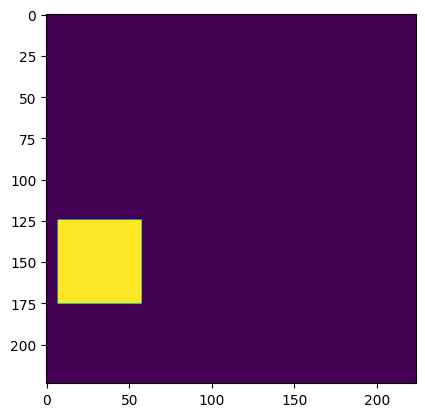

In [266]:
def restrict_neighborhood(h, w, size_neighborhood, x, y):
    # We restrict the set of source nodes considered to a spatial neighborhood of the query node (i.e. ``local attention'')
    # write a faster version of the above function
    mask = torch.zeros(h, w)
    y_start = max(0, y - size_neighborhood)
    y_end = min(h, y + size_neighborhood + 1)
    x_start = max(0, x - size_neighborhood)
    x_end = min(w, x + size_neighborhood + 1)
    mask[y_start:y_end, x_start:x_end] = 1
    # mask = mask * (mask == 1)

    return mask

mask = restrict_neighborhood(224, 224, 25, 32, 150).cuda()
print(mask.unique())
plt.imshow(mask.cpu().numpy())

In [264]:
def find_closest_point(
    target_feats: torch.Tensor,
    source_feats: torch.Tensor,
    source_point: torch.Tensor,
    offset: int = 0,
    size_neighborhood: int = 5,
    out_put_similarity=False,
):
    source_point = source_point.long()

    source_point_feat = source_feats[:, source_point[1], source_point[0]]
    target_vec = rearrange(target_feats, "c h w -> (h w) c")
    source_vec = rearrange(source_point_feat, "c -> () c")
    # compute the cosine similarity between the source point feature and all the target features
    similarity = F.cosine_similarity(target_vec, source_vec, dim=1)
    # find the index of the most similar target feature
    similarity = rearrange(
        similarity, "(h w) -> h w", h=target_feats.shape[1], w=target_feats.shape[2]
    )
    attn_mask = restrict_neighborhood(
        target_feats.shape[1],
        target_feats.shape[2],
        size_neighborhood,
        source_point[0],
        source_point[1],
    )
    similarity = similarity * attn_mask.cuda()
    target_point = torch.argmax(similarity)
    # unravel the index to get the target point coordinates
    target_point = torch.tensor(
        np.unravel_index(target_point.detach().cpu().numpy(), similarity.shape)
    )
    target_point = target_point.flip(0)
    target_point[0] += offset
    if out_put_similarity:
        target_similarity = similarity[target_point[1], target_point[0] - offset]
        return target_point, target_similarity
    return target_point

In [9]:
video_idx = 4
frame_source_idx = 0
frame_target_idx = 15
neighor_size = 28

/work3/s232248/miniconda3/envs/rd/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


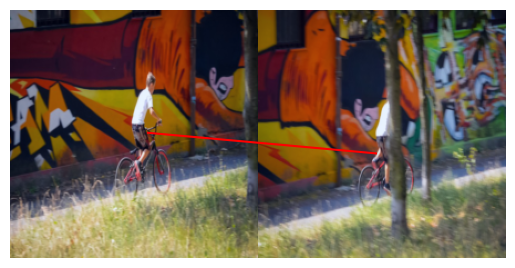

In [10]:
source_img_tensor, source_mask, source_points = val_infer_set.raw_data_set[video_idx][
    frame_source_idx
]
target_img_tensor, target_mask, target_points_set = val_infer_set.raw_data_set[video_idx][
    frame_target_idx
]
source_img = normalize(source_img_tensor).permute(1, 2, 0).numpy()
target_img = normalize(target_img_tensor).permute(1, 2, 0).numpy()
total_img = np.concatenate([source_img, target_img], axis=1)
plt.imshow(total_img)
source_points = source_points.clamp(0, 223).numpy()
point_colors = ["r", "g", "b", "y", "m", "c"]
color_array = np.array([point_colors[i % len(point_colors)] for i in range(source_points.shape[0])])
# plt.scatter(source_points[:, 0], source_points[:, 1], c=color_array, s=5)
source_feats = featup(source_img_tensor.unsqueeze(0).cuda()).squeeze(0)
target_feats = featup(target_img_tensor.unsqueeze(0).cuda()).squeeze(0)
point_idx = 0
source_point = source_points[point_idx]
# plt.scatter(source_point[0], source_point[1], c='r', s=5)
source_feat = source_feats[:, source_point[1].astype(int), source_point[0].astype(int)]
img_offset = source_img.shape[1]
closest_point = find_closest_point(target_feats, source_feats, torch.tensor(source_point), img_offset, neighor_size)
# plt.scatter(closest_point[1], closest_point[0], c='b', s=5)
plt.plot([source_point[0], closest_point[0]], [source_point[1], closest_point[1]], c='r')

plt.axis("off")
plt.show()

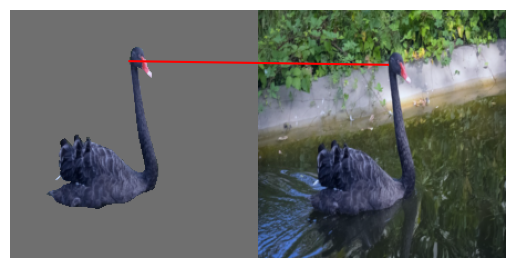

In [268]:
source_img_tensor, source_mask, source_points = val_infer_set.raw_data_set[video_idx][
    frame_source_idx
]
target_img_tensor, target_mask, target_points_set = val_infer_set.raw_data_set[video_idx][
    frame_target_idx
]
source_img_tensor *= source_mask
source_img = normalize(source_img_tensor).permute(1, 2, 0).numpy()
target_img = normalize(target_img_tensor).permute(1, 2, 0).numpy()
total_img = np.concatenate([source_img, target_img], axis=1)
plt.imshow(total_img)
source_points = source_points.clamp(0, 223).numpy()
point_colors = ["r", "g", "b", "y", "m", "c"]
color_array = np.array([point_colors[i % len(point_colors)] for i in range(source_points.shape[0])])
# plt.scatter(source_points[:, 0], source_points[:, 1], c=color_array, s=5)
source_feats = featup(source_img_tensor.unsqueeze(0).cuda()).squeeze(0)
target_feats = featup(target_img_tensor.unsqueeze(0).cuda()).squeeze(0)
point_idx = 0
source_point = source_points[point_idx]
# plt.scatter(source_point[0], source_point[1], c='r', s=5)
source_feat = source_feats[:, source_point[1].astype(int), source_point[0].astype(int)]
img_offset = source_img.shape[1]
closest_point, point_similarity = find_closest_point(target_feats, source_feats, torch.tensor(source_point), img_offset, neighor_size, out_put_similarity=True)
# plt.scatter(closest_point[1], closest_point[0], c='b', s=5)
plt.plot([source_point[0], closest_point[0]], [source_point[1], closest_point[1]], c='r')

plt.axis("off")
plt.show()

In [109]:
class Featup_wrapperFir(nn.Module):
    def __init__(self, model: nn.Module, neighor_size: int = 28, mask_frame: bool = False):
        super().__init__()
        self.model = model
        self.neighor_size = neighor_size
        self.mask_frame = mask_frame
        

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        if self.mask_frame:
            fir_img = fir_img * pre_sgm
        fir_img_feats = self.model(fir_img).squeeze(0)
        cur_img_feats = self.model(cur_img).squeeze(0)
        cur_points = []
        fir_bou = fir_bou.squeeze(0).clamp(0, 223).float()
        for i in range(fir_bou.shape[0]):
            fir_point = fir_bou[i]
            cur_point = find_closest_point(
                cur_img_feats,
                fir_img_feats,
                fir_point,
                0,
                self.neighor_size,
            )
            cur_points.append(cur_point)
        cur_points = torch.stack(cur_points).to(fir_bou.device)
        cur_points = cur_points.unsqueeze(0)
        return cur_points.float()

In [301]:
val_inferer = VideoInferer(val_infer_set, gt_rasterizer)

In [ ]:
featup_wrapper = Featup_wrapperFir(featup, neighor_size, mask_frame=False).cuda()

In [23]:
val_inferer.infer_all_videos(featup_wrapper, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [13:49<00:00, 14.56s/it]


In [24]:
val_inferer.compute_all_videos_iou()

0.2690629926067169

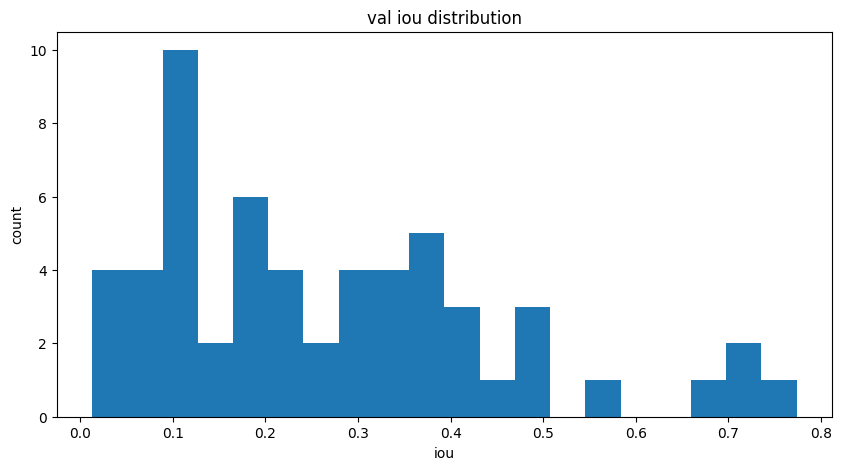

In [25]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 22]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [258]:
video_idx = 2
frame_source_idx = 0
frame_target_idx = 15
neighor_size = 28
bou_feats_mem = []
bou_points_mem = []

In [261]:
fir_img_tensor, fir_mask, fir_points = val_infer_set.raw_data_set[video_idx][0]
# for i in range(14):
#     pre_img_tensor, pre_mask, pre_points = val_infer_set.raw_data_set[video_idx][i]
#     cur_img_tensor, cur_mask, cur_points = val_infer_set.raw_data_set[video_idx][i + 1]
#     with torch.no_grad():
#         pred_points = featup_wrapper(
#             fir_img_tensor.unsqueeze(0).cuda(),
#             fir_points.unsqueeze(0).cuda(),
#             pre_img_tensor.unsqueeze(0).cuda(),
#             pre_points.unsqueeze(0).cuda(),
#             pre_mask.unsqueeze(0).cuda(),
#             cur_img_tensor.unsqueeze(0).cuda(),
#         )
#         cur_img_feats = featup(cur_img_tensor.unsqueeze(0).cuda())
#     pred_bou_feats = get_bou_feats(cur_img_feats, pred_points.long())
#     bou_feats_mem.append(pred_bou_feats)
#     bou_points_mem.append(pred_points)

In [17]:
bou_feats_mem_tensor = torch.cat(bou_feats_mem, dim=0)
bou_points_mem_tensor = torch.cat(bou_points_mem, dim=0)
bou_feats_mem_tensor.shape, bou_points_mem_tensor.shape

(torch.Size([14, 64, 384]), torch.Size([14, 64, 2]))

In [18]:
bou_feats_mem_tensor = bou_feats_mem_tensor.cuda()

NameError: name 'source_points' is not defined

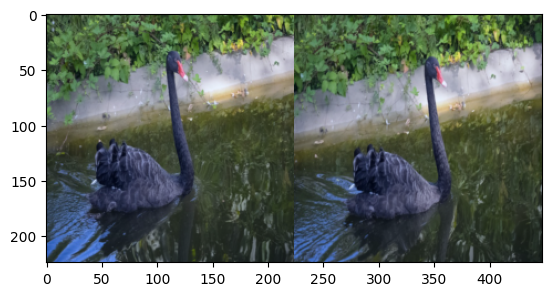

In [262]:
target_img_tensor, target_mask, target_points_set = val_infer_set.raw_data_set[video_idx][frame_target_idx]
target_img_feats = featup(target_img_tensor.unsqueeze(0).cuda()).squeeze(0)

fir_img = normalize(fir_img_tensor).permute(1, 2, 0).numpy()
target_img = normalize(target_img_tensor).permute(1, 2, 0).numpy()
total_img = np.concatenate([fir_img, target_img], axis=1)
plt.imshow(total_img)
point_colors = ["r", "g", "b", "y", "m", "c"]
color_array = np.array([point_colors[i % len(point_colors)] for i in range(source_points.shape[0])])
point_idx = 0
source_point = bou_points_mem_tensor[0][point_idx].detach().cpu().numpy()
plt.scatter(source_point[0], source_point[1], c='r', s=5)

In [20]:
target_img_feats.shape, bou_feats_mem_tensor.shape, bou_points_mem_tensor.shape

(torch.Size([384, 224, 224]),
 torch.Size([14, 64, 384]),
 torch.Size([14, 64, 2]))

In [259]:
def find_closest_points_mem(
    target_feats: torch.Tensor,
    source_feats_mem: torch.Tensor,
    source_points_mem: torch.Tensor,
    size_neighborhood: int = 5,
    top_k: int = 10,
    weight_avg: bool = False,
):
    # print(target_feats.shape, source_feats_mem.shape, source_points_mem.shape)
    target_vec = rearrange(target_feats, "c h w -> (h w) c")
    source_vec = rearrange(source_feats_mem, "f p c -> c (f p)")
    target_vec = F.normalize(target_vec, p=2, dim=1)
    source_vec = F.normalize(source_vec, p=2, dim=0)

    affinity = target_vec @ source_vec
    affinity = rearrange(
        affinity,
        "(h w) (f p) -> f p h w",
        h=target_feats.shape[1],
        w=target_feats.shape[2],
        f=source_feats_mem.shape[0],
        p=source_feats_mem.shape[1],
    )
    point_mask = []
    for frame_idx in range(source_points_mem.shape[0]):
        for point_idx in range(source_points_mem.shape[1]):
            point = source_points_mem[frame_idx][point_idx].long()
            mask = restrict_neighborhood(
                target_feats.shape[1],
                target_feats.shape[2],
                size_neighborhood,
                point[0],
                point[1],
            )
            point_mask.append(mask)
    point_mask = torch.stack(point_mask).cuda()
    point_mask = rearrange(
        point_mask,
        "(f p) h w -> f p h w",
        h=target_feats.shape[1],
        w=target_feats.shape[2],
        f=source_feats_mem.shape[0],
        p=source_feats_mem.shape[1],
    )
    affinity = affinity * point_mask
    affinity = rearrange(
        affinity,
        "f p h w -> f p (h w)",
        h=target_feats.shape[1],
        w=target_feats.shape[2],
    )
    # print(affinity.shape)
    target_similarity, target_point = torch.max(affinity, dim=2)
    # print(target_similarity.shape, target_point.shape)
    top_k = min(top_k, source_points_mem.shape[0])
    # print(top_k)
    top_k_similarity, top_k_idx = torch.topk(target_similarity, top_k, dim=0)
    # print(top_k_similarity.shape, top_k_idx.shape)
    # print(top_k_idx)
    # get the top k points from target_point using top_k_idx
    top_k_points = torch.gather(target_point, 0, top_k_idx).cuda()
    # print((torch.gather(target_similarity, 0, top_k_idx) == top_k_similarity).all())
    # print(top_k_points.shape)
    # tmp_k_points = torch.zeros_like(top_k_points)
    # for i in range(top_k_idx.shape[0]):
    #     for j in range(top_k_idx.shape[1]):
    #         tmp_k_points[i][j] = target_point[top_k_idx[i][j]][j]
    # print((tmp_k_points == top_k_points).all())
    # unravel the index to get the target point coordinates
    # print(top_k_points.shape)
    top_k_points = torch.tensor(
        np.unravel_index(top_k_points.detach().cpu().numpy(), target_feats.shape[1:])
    ).cuda()
    top_k_points = top_k_points.flip(0)
    if not weight_avg:
        result = top_k_points.float().mean(dim=1)
    else:
        # get weight similarity average of the top k points
        result = top_k_points * top_k_similarity
        result = result.sum(dim=1) / top_k_similarity.sum(dim=0)

    return result.permute(1, 0)


find_closest_points_mem(
    target_img_feats, bou_feats_mem_tensor, bou_points_mem_tensor, weight_avg=True
).shape

NameError: name 'target_img_feats' is not defined

In [257]:
target_img_tensor, target_mask, target_points_set = val_infer_set.raw_data_set[video_idx][frame_target_idx]
target_img_feats = featup(target_img_tensor.unsqueeze(0).cuda()).squeeze(0)
fir_img_tensor *= target_mask
fir_img = normalize(fir_img_tensor).permute(1, 2, 0).numpy()
target_img = normalize(target_img_tensor).permute(1, 2, 0).numpy()
total_img = np.concatenate([fir_img, target_img], axis=1)
plt.imshow(total_img)
point_colors = ["r", "g", "b", "y", "m", "c"]
color_array = np.array([point_colors[i % len(point_colors)] for i in range(source_points.shape[0])])
point_idx = 62
source_point = bou_points_mem_tensor[0][point_idx].detach().cpu().numpy()
closest_points = find_closest_points_mem(target_img_feats, bou_feats_mem_tensor, bou_points_mem_tensor, weight_avg=True)
target_point = closest_points[point_idx].detach().cpu().numpy()
plt.scatter(source_point[0], source_point[1], c='r', s=5)
plt.scatter(target_point[0] + 224, target_point[1], c='r', s=5)
plt.axis("off")
plt.show()

NameError: name 'frame_target_idx' is not defined

In [98]:
class Featup_wrapperMem(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        neighor_size: int = 28,
        mask_pre_frame: bool = False,
        top_k: int = 10,
        mem_size: int = 28,
        weight_avg: bool = False,
    ) -> None:
        super().__init__()
        self.model = model
        self.neighor_size = neighor_size
        self.mask_pre_frame = mask_pre_frame
        self.top_k = top_k
        self.mem_size = mem_size
        self.weight_avg = weight_avg
        self.reset()

    def reset(self):
        self.feats_mem = []
        self.points_mem = []
        self.fir_feats = None
        self.fir_points = None
    
    def eval(self):
        super().eval()
        self.reset()
    
    def add_mem(self, img_feats: torch.Tensor, points: torch.Tensor):
        point_feats = get_bou_feats(img_feats, points.long())
        if self.fir_feats is None:
            self.fir_feats = point_feats
            self.fir_points = points
        else:
            self.feats_mem.append(point_feats)
            self.points_mem.append(points)
            if len(self.feats_mem) > self.mem_size:
                self.feats_mem.pop(0)
                self.points_mem.pop(0)
    
    def get_mem_tensor(self):
        total_feats_mem = self.feats_mem + [self.fir_feats]
        total_points_mem = self.points_mem + [self.fir_points]
        total_feats_mem = torch.cat(total_feats_mem, dim=0)
        total_points_mem = torch.cat(total_points_mem, dim=0)
        return total_feats_mem, total_points_mem
    
    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        pre_bou = pre_bou.clamp(0, 223)
        fir_bou = fir_bou.clamp(0, 223)
        if self.mask_pre_frame:
            pre_img = pre_img * pre_sgm
        pre_img_feats = self.model(pre_img)
        self.add_mem(pre_img_feats, pre_bou)
        cur_img_feats = self.model(cur_img).squeeze(0)
        cur_points = find_closest_points_mem(
            cur_img_feats,
            *self.get_mem_tensor(),
            self.neighor_size,
            self.top_k,
            self.weight_avg,
        ).unsqueeze(0).to(fir_bou.device)
        return cur_points.float().contiguous()

In [90]:
featup_wrapper_mem = Featup_wrapperMem(featup, neighor_size, mask_pre_frame=False).cuda()

In [91]:
fir_img_tensor, fir_mask, fir_points = val_infer_set.raw_data_set[video_idx][0]

In [92]:
pred_points = featup_wrapper_mem(
    fir_img_tensor.unsqueeze(0).cuda(),
    fir_points.unsqueeze(0).cuda(),
    fir_img_tensor.unsqueeze(0).cuda(),
    fir_points.unsqueeze(0).cuda(),
    fir_mask.unsqueeze(0).cuda(),
    target_img_tensor.unsqueeze(0).cuda(),
)
pred_points.shape

torch.Size([1, 64, 2])

In [93]:
val_inferer.infer_all_videos(featup_wrapper_mem, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [37:02<00:00, 38.99s/it]


In [95]:
val_inferer.compute_all_videos_iou()

0.23471900657305841

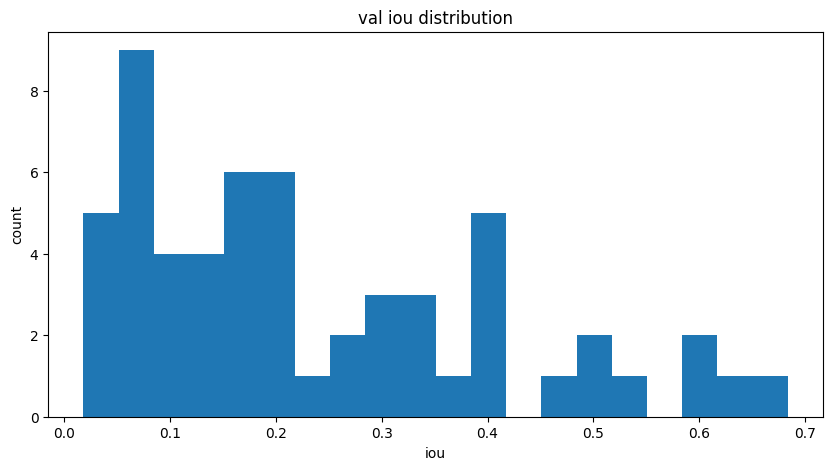

In [96]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 22]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [102]:
featup_wrapper_mem = Featup_wrapperMem(featup, neighor_size, mask_pre_frame=False, weight_avg=True).cuda()

In [103]:
val_inferer.infer_all_videos(featup_wrapper_mem, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [37:00<00:00, 38.95s/it]


In [104]:
val_inferer.compute_all_videos_iou()

0.22805904050328726

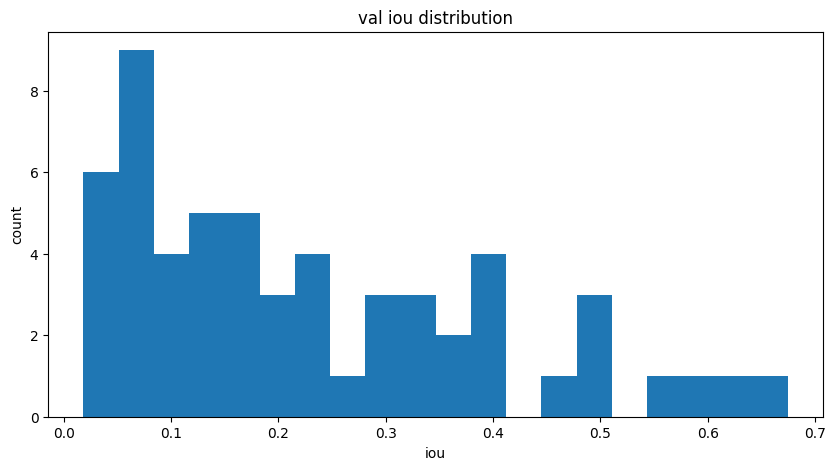

In [105]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 22]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [110]:
featup_wrapper = Featup_wrapperFir(featup, neighor_size, mask_frame=True).cuda()

In [111]:
val_inferer.infer_all_videos(featup_wrapper, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [13:39<00:00, 14.39s/it]


In [112]:
val_inferer.compute_all_videos_iou()

0.1908707550930435

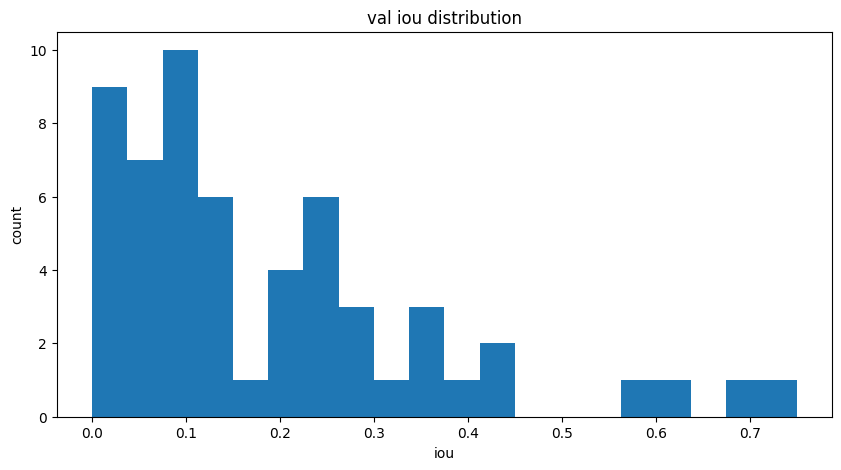

In [114]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 22]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [123]:
featup_wrapper_mem = Featup_wrapperMem(featup, neighor_size, mask_pre_frame=True).cuda()

In [124]:
val_inferer.infer_all_videos(featup_wrapper_mem, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [45:59<00:00, 48.42s/it]


In [125]:
val_inferer.compute_all_videos_iou()

0.16786376117515234

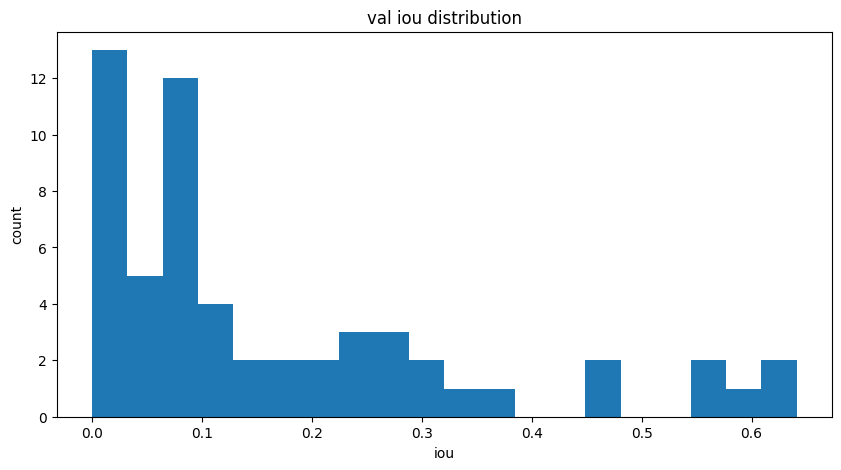

In [126]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 22]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

In [128]:
featup_wrapper_mem = Featup_wrapperMem(featup, neighor_size, mask_pre_frame=True, weight_avg=True).cuda()

In [129]:
val_inferer.infer_all_videos(featup_wrapper_mem, use_tqdm=True)

  0%|                                                                                                                                                       | 0/57 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [40:13<00:00, 42.33s/it]


In [130]:
val_inferer.compute_all_videos_iou()

0.16822703979463985

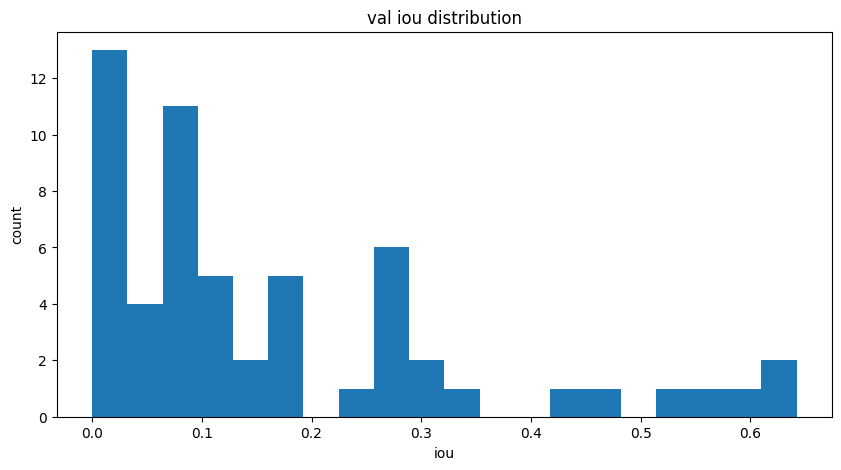

In [131]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 22]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

## Boundary Classifier

In [12]:
video_idx = 2
frame_idx = 22


In [13]:
img_tensor, mask, points = val_infer_set.raw_data_set[video_idx][frame_idx]

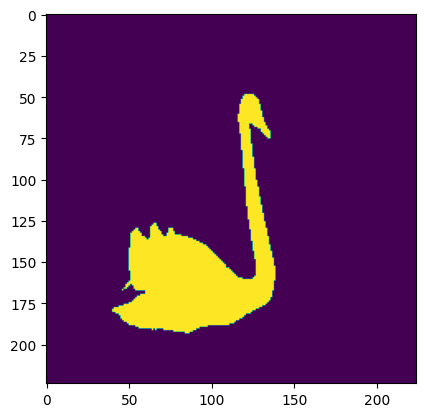

In [14]:
plt.imshow(mask)

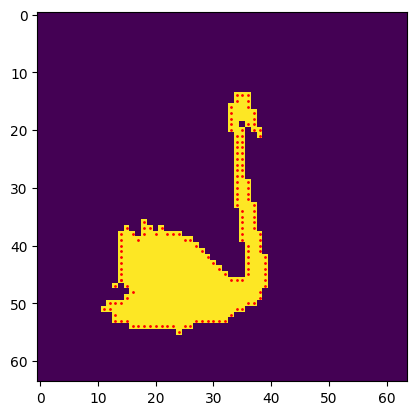

In [17]:
small_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), (64, 64), mode="bilinear").squeeze(0).squeeze(0)
small_mask[small_mask > 0.0] = 1.0
mask_numpy = small_mask.numpy()
mask_numpy = mask_numpy.astype(np.uint8)
boundaries, contours = cv.findContours(
    mask_numpy, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE
)
boundaries = [np.squeeze(boundary, axis=1) for boundary in boundaries]
for boundary in boundaries:
    plt.scatter(boundary[:, 0], boundary[:, 1], c="r", s=1)
plt.imshow(small_mask)

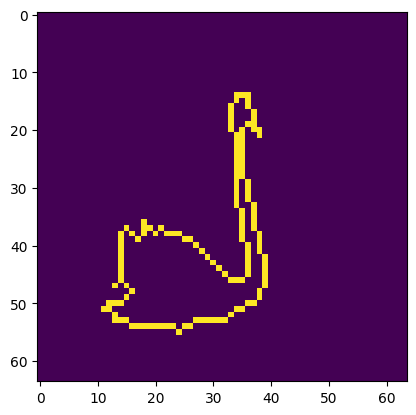

In [18]:
boundary_img = np.zeros_like(mask_numpy)
for boundary in boundaries:
    boundary_img[boundary[:, 1], boundary[:, 0]] = 1
plt.imshow(boundary_img)

(tensor(3847), tensor(0.0767))

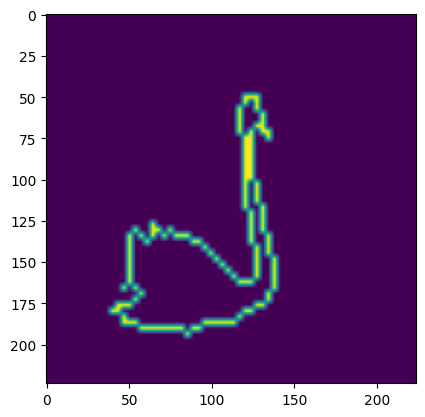

In [19]:
boundary_img_tensor = torch.tensor(boundary_img)
boundary_img_tensor = boundary_img_tensor.unsqueeze(0).unsqueeze(0).float()
boundary_img_tensor = F.interpolate(boundary_img_tensor, (224, 224), mode="bilinear").squeeze(0).squeeze(0)
plt.imshow(boundary_img_tensor)
(boundary_img_tensor > 0.0).sum(), (boundary_img_tensor > 0.0).sum() / (224 * 224)

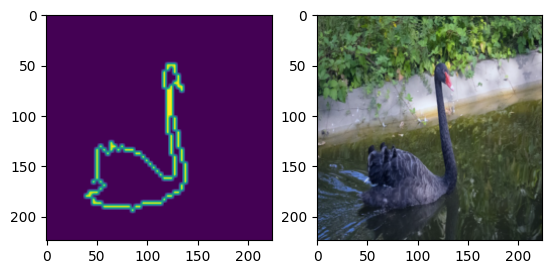

In [23]:
def get_boundary_mask(
    mask: torch.Tensor, size: int = 64, device: str = "cuda"
) -> torch.Tensor:
    small_mask = (
        F.interpolate(
            mask.unsqueeze(0).unsqueeze(0).float(), (size, size), mode="bilinear"
        )
        .squeeze(0)
        .squeeze(0)
    )
    small_mask[small_mask > 0.0] = 1.0
    mask_numpy = small_mask.cpu().numpy()
    mask_numpy = mask_numpy.astype(np.uint8)
    boundaries, _ = cv.findContours(mask_numpy, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    boundaries = [np.squeeze(boundary, axis=1) for boundary in boundaries]
    boundary_img = np.zeros_like(mask_numpy)
    for boundary in boundaries:
        boundary_img[boundary[:, 1], boundary[:, 0]] = 1
    boundary_img_tensor = torch.tensor(boundary_img)
    boundary_img_tensor = (
        boundary_img_tensor.unsqueeze(0).unsqueeze(0).float().to(device)
    )
    boundary_img_tensor = (
        F.interpolate(boundary_img_tensor, (224, 224), mode="bilinear")
        .squeeze(0)
        .squeeze(0)
    )
    return boundary_img_tensor



boundary_img_tensor = get_boundary_mask(mask, 64, "cuda")
# print(boundary_img_tensor.unique())
plt.subplot(1, 2, 1)
plt.imshow(boundary_img_tensor.cpu())
plt.subplot(1, 2, 2)
plt.imshow(normalize(img_tensor).permute(1, 2, 0).cpu().numpy())

tensor([0., 1.], device='cuda:0')


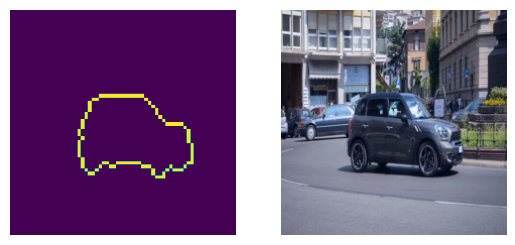

In [8]:
def get_binary_boundary_mask(
    mask: torch.Tensor, size: int = 64, device: str = "cuda"
) -> torch.Tensor:
    small_mask = (
        F.interpolate(
            mask.unsqueeze(0).unsqueeze(0).float(), (size, size), mode="nearest"
        )
        .squeeze(0)
        .squeeze(0)
    )
    small_mask[small_mask > 0.0] = 1.0
    mask_numpy = small_mask.cpu().numpy()
    mask_numpy = mask_numpy.astype(np.uint8)
    boundaries, _ = cv.findContours(mask_numpy, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    boundaries = [np.squeeze(boundary, axis=1) for boundary in boundaries]
    boundary_img = np.zeros_like(mask_numpy)
    for boundary in boundaries:
        boundary_img[boundary[:, 1], boundary[:, 0]] = 1
    boundary_img_tensor = torch.tensor(boundary_img)
    boundary_img_tensor = (
        boundary_img_tensor.unsqueeze(0).unsqueeze(0).float().to(device)
    )
    boundary_img_tensor = (
        F.interpolate(boundary_img_tensor, (224, 224), mode="nearest")
        .squeeze(0)
        .squeeze(0)
    )
    return boundary_img_tensor


boundary_img_tensor = get_binary_boundary_mask(mask, 64, "cuda")
print(boundary_img_tensor.unique())
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(boundary_img_tensor.cpu())
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(normalize(img_tensor).permute(1, 2, 0).cpu().numpy())

In [160]:
boundary_classifier = MLP(384, 384, 1, 3).cuda()

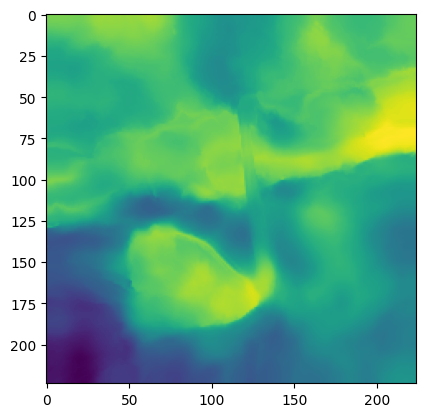

In [169]:
img_feats = featup(img_tensor.unsqueeze(0).cuda()).squeeze(0)
img_feats = rearrange(img_feats, "c h w -> (h w) c")
pred_bou_results = boundary_classifier(img_feats).sigmoid()
pred_bou_results = rearrange(pred_bou_results, "(h w) c -> h w c", h=224, w=224)
plt.imshow(pred_bou_results.cpu().detach().numpy())

In [10]:
class BoundaryClassifier(nn.Module):
    def __init__(
        self,
        freeze_featup: bool = True,
    ) -> None:
        super().__init__()
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        ).cuda()
        if freeze_featup:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_model = 384
        self.classifier = MLP(d_model, d_model, 1, 3).cuda()

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        img_feats = self.featup(img)
        img_feats = rearrange(img_feats, "b c h w -> b (h w) c")
        pred_bou_results = self.classifier(img_feats).sigmoid()
        pred_bou_results = rearrange(
            pred_bou_results, "b (h w) () -> b h w", h=img.shape[2], w=img.shape[3]
        )
        return pred_bou_results

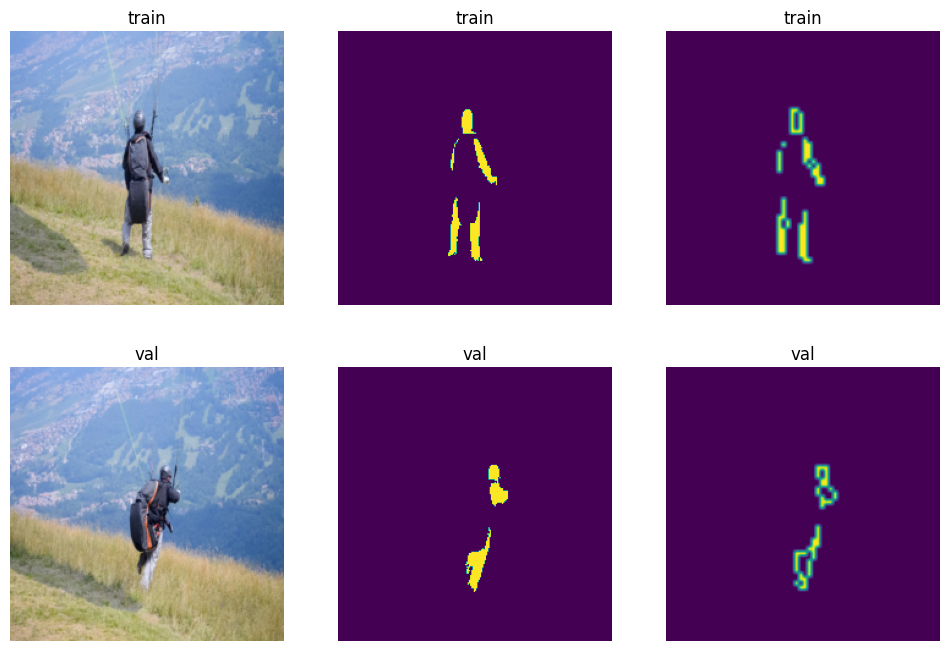

In [60]:
video_idx = 42
frame_idx = 0
img_tensor, mask, points = val_infer_set.raw_data_set[video_idx][frame_idx]
val_frame_idx = 25
val_img_tensor, val_mask, val_points = val_infer_set.raw_data_set[video_idx][val_frame_idx]
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title("train")
plt.axis("off")
plt.imshow(normalize(img_tensor).permute(1, 2, 0).cpu().numpy())
plt.subplot(2, 3, 2)
plt.title("train")
plt.axis("off")
plt.imshow(mask.cpu())
plt.subplot(2, 3, 3)
plt.title("train")
plt.axis("off")
boundary_img_tensor = get_boundary_mask(mask, 64, "cuda")
plt.imshow(boundary_img_tensor.cpu())
plt.subplot(2, 3, 4)
plt.title("val")
plt.axis("off")
plt.imshow(normalize(val_img_tensor).permute(1, 2, 0).cpu().numpy())
plt.subplot(2, 3, 5)
plt.title("val")
plt.axis("off")
plt.imshow(val_mask.cpu())
plt.subplot(2, 3, 6)
plt.title("val")
plt.axis("off")
val_boundary_img_tensor = get_boundary_mask(val_mask, 64, "cuda")
plt.imshow(val_boundary_img_tensor.cpu())
plt.show()

In [24]:
boundary_classifier = BoundaryClassifier(featup).cuda()
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(boundary_classifier.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [25]:
loss_dict = {}
val_loss_dict = {}
epoch_num =  60

In [26]:
for e in range(epoch_num):
    total_loss = 0.0
    pred_bou_results = boundary_classifier(img_tensor.unsqueeze(0).cuda())
    # print(pred_bou_results.shape, boundary_img_tensor.shape)
    loss = mse_loss(pred_bou_results, boundary_img_tensor.unsqueeze(0))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    loss_dict[e] = total_loss / len(val_infer_set.raw_data_set)
    val_loss = 0.0
    val_pred_bou_results = boundary_classifier(val_img_tensor.unsqueeze(0).cuda())
    val_loss = mse_loss(val_pred_bou_results, val_boundary_img_tensor.unsqueeze(0))
    val_loss_dict[e] = val_loss.item()
    print(f"epoch {e} loss: {loss_dict[e]} val_loss: {val_loss.item()}")

epoch 0 loss: 0.004437590900220369 val_loss: 0.2434529811143875
epoch 1 loss: 0.004204281066593371 val_loss: 0.23084557056427002
epoch 2 loss: 0.003994543824279518 val_loss: 0.21774454414844513
epoch 3 loss: 0.00378204882144928 val_loss: 0.20722728967666626
epoch 4 loss: 0.003566111911807144 val_loss: 0.19562260806560516
epoch 5 loss: 0.003374279591075161 val_loss: 0.18391983211040497
epoch 6 loss: 0.003156642380513643 val_loss: 0.17114797234535217
epoch 7 loss: 0.0029592351955279967 val_loss: 0.16438028216362
epoch 8 loss: 0.0029059018482241713 val_loss: 0.15343567728996277
epoch 9 loss: 0.0027324763829247992 val_loss: 0.14197011291980743
epoch 10 loss: 0.0026038108687651785 val_loss: 0.13438738882541656
epoch 11 loss: 0.0023105573235896594 val_loss: 0.126925989985466
epoch 12 loss: 0.002206695184373019 val_loss: 0.118548683822155
epoch 13 loss: 0.0018267757014224404 val_loss: 0.10841655731201172
epoch 14 loss: 0.001896629600148452 val_loss: 0.10171796381473541
epoch 15 loss: 0.001753

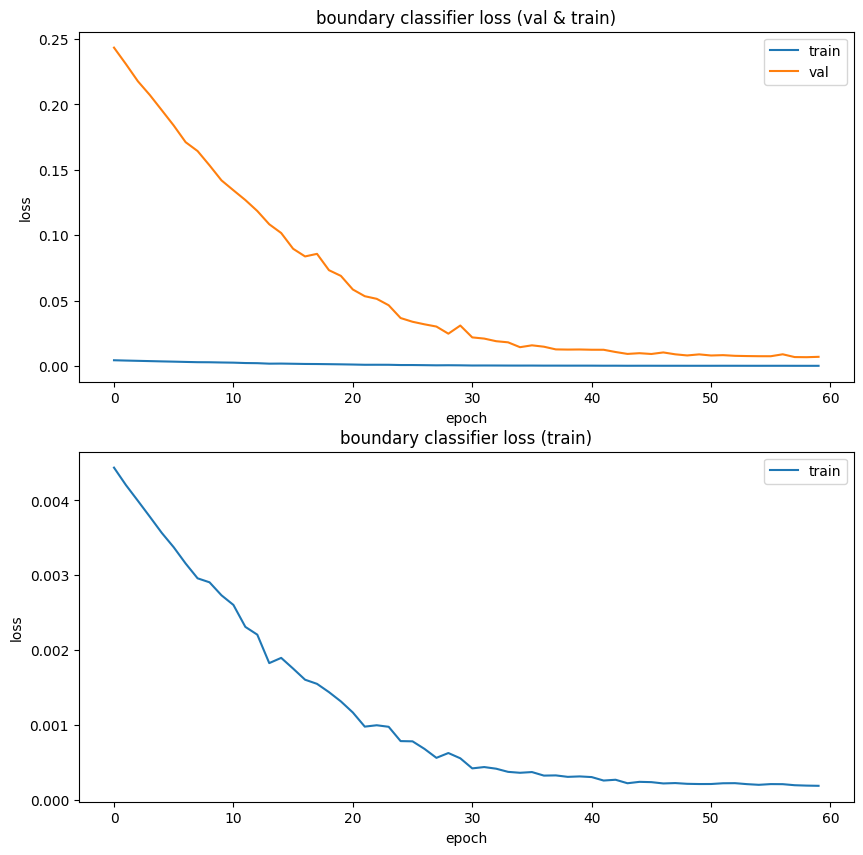

In [27]:
# plot the loss curve
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="train")
plt.plot(list(val_loss_dict.keys()), list(val_loss_dict.values()), label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("boundary classifier loss (val & train)")
plt.subplot(2, 1, 2)
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="train")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("boundary classifier loss (train)")
plt.show()

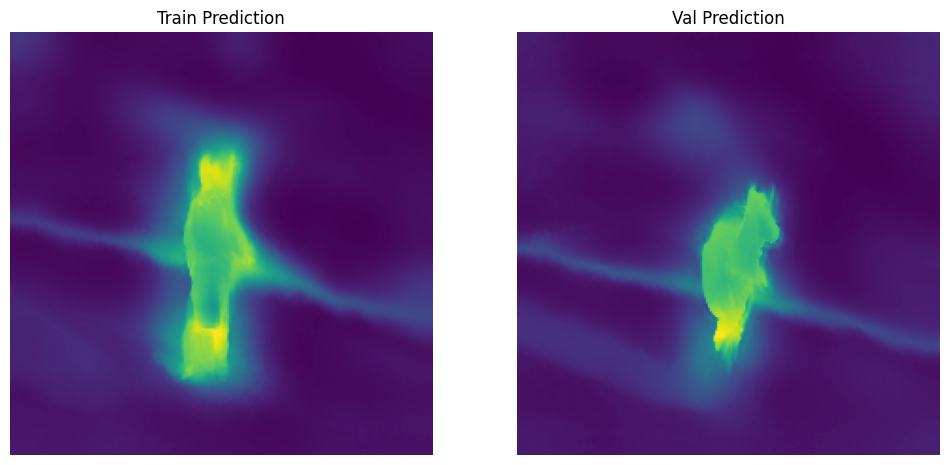

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(pred_bou_results[0].cpu().detach().numpy())
plt.axis("off")
plt.title("Train Prediction")
plt.subplot(1, 2, 2)
plt.imshow(val_pred_bou_results[0].cpu().detach().numpy())
plt.axis("off")
plt.title("Val Prediction")
plt.show()

In [297]:
val_pred_boundary_img_tensor = boundary_classifier(val_img_tensor.unsqueeze(0).cuda())
val_pred_boundary_img_tensor.shape

torch.Size([1, 224, 224])

In [429]:
def find_closest_point_withBouPoss(
    target_feats: torch.Tensor,
    source_feats: torch.Tensor,
    source_point: torch.Tensor,
    Boundary_possibility: torch.Tensor,
    offset: int = 0,
    size_neighborhood: int = 5,
    out_put_similarity=False,
):
    source_point = source_point.long()

    source_point_feat = source_feats[:, source_point[1], source_point[0]]
    target_vec = rearrange(target_feats, "c h w -> (h w) c")
    source_vec = rearrange(source_point_feat, "c -> () c")
    # compute the cosine similarity between the source point feature and all the target features
    similarity = F.cosine_similarity(target_vec, source_vec, dim=1)
    # find the index of the most similar target feature
    similarity = rearrange(
        similarity, "(h w) -> h w", h=target_feats.shape[1], w=target_feats.shape[2]
    )
    attn_mask = restrict_neighborhood(
        target_feats.shape[1],
        target_feats.shape[2],
        size_neighborhood,
        source_point[0],
        source_point[1],
    )
    similarity = similarity / similarity.max()
    similarity = (similarity + Boundary_possibility) * attn_mask.cuda()
    target_point = torch.argmax(similarity)
    # unravel the index to get the target point coordinates
    target_point = torch.tensor(
        np.unravel_index(target_point.detach().cpu().numpy(), similarity.shape)
    )
    target_point = target_point.flip(0)
    target_point[0] += offset
    if out_put_similarity:
        target_similarity = similarity[target_point[1], target_point[0] - offset]
        return target_point, target_similarity
    return target_point

In [430]:
class Featup_wrapperFir_Classifier(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        neighor_size: int = 28,
        mask_frame: bool = False,
        fit_epoch_num: int = 60,
        bou_poss_weight: float = 1,
    ):
        super().__init__()
        self.model = model
        self.neighor_size = neighor_size
        self.mask_frame = mask_frame
        self.boundary_classifier = BoundaryClassifier()
        self.classifier_loss = nn.MSELoss()
        self.fit_epoch_num = fit_epoch_num
        self.have_fit = False
        self.bou_poss_weight = bou_poss_weight

    def eval(self):
        super().eval()
        self.have_fit = False
        return self

    def fit_classifier(self, img_tensor: torch.Tensor, mask: torch.Tensor):
        mask = mask.squeeze(0)
        boundary_img_tensor = get_boundary_mask(mask, 64, "cuda")
        optimizer = torch.optim.Adam(self.boundary_classifier.parameters(), lr=1e-4)
        for e in range(self.fit_epoch_num):
            total_loss = 0.0
            pred_bou_results = self.boundary_classifier(img_tensor)
            loss = self.classifier_loss(
                pred_bou_results, boundary_img_tensor.unsqueeze(0)
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        self.have_fit = True

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        if not self.have_fit:
            self.fit_classifier(fir_img, fir_bou)
        if self.mask_frame:
            fir_img = fir_img * pre_sgm
        fir_img_feats = self.model(fir_img).squeeze(0)
        cur_img_feats = self.model(cur_img).squeeze(0)
        cur_points = []
        fir_bou = fir_bou.squeeze(0).clamp(0, 223).float()
        cur_bou_poss = self.boundary_classifier(cur_img)[0]
        cur_bou_poss = cur_bou_poss / cur_bou_poss.max()
        cur_bou_poss = cur_bou_poss * self.bou_poss_weight
        for i in range(fir_bou.shape[0]):
            fir_point = fir_bou[i]
            cur_point = find_closest_point_withBouPoss(
                cur_img_feats,
                fir_img_feats,
                fir_point,
                cur_bou_poss,
                0,
                self.neighor_size,
            )
            cur_points.append(cur_point)
        cur_points = torch.stack(cur_points).to(fir_bou.device)
        cur_points = cur_points.unsqueeze(0)
        return cur_points.float()

In [431]:
featup_wrapper_fir_classifier = Featup_wrapperFir_Classifier(featup, neighor_size, mask_frame=False, bou_poss_weight=0.1).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [432]:
class VideoInferer:
    def __init__(
        self,
        dataset: DAVIS_withPointRandom,
        gt_rasterizer: SoftPolygon,
    ) -> None:
        self.data_set = dataset.raw_data_set
        self.gt_rasterizer = gt_rasterizer

    def infer_one_video(self, video_idx: int, model: nn.Module, use_grad: bool = False):
        infer_results = []
        video_data = self.data_set[video_idx]
        model.eval()
        fir_img, fir_mask, fir_point = video_data[0]
        pre_img, pre_mask, pre_point = video_data[0]
        fir_img = fir_img.unsqueeze(0)
        pre_img = pre_img.unsqueeze(0)
        fir_mask = fir_mask.unsqueeze(0)
        pre_mask = pre_mask.unsqueeze(0)
        fir_point = fir_point.unsqueeze(0)
        pre_point = pre_point.unsqueeze(0)
        infer_results.append(None)
        for i in range(1, len(video_data)):
            cur_img, cur_mask, cur_point = video_data[i]
            cur_img = cur_img.unsqueeze(0)
            cur_mask = cur_mask.unsqueeze(0)
            cur_point = cur_point.unsqueeze(0)
            pred_bou = model(
                fir_img.cuda(),
                fir_point.cuda(),
                pre_img.cuda(),
                pre_point.cuda(),
                pre_mask.cuda(),
                cur_img.cuda(),
            )
            pred_mask = self.gt_rasterizer(pred_bou, 224, 224)
            pred_mask[pred_mask == -1] = 0
            iou = get_batch_average_bou_iou(
                pred_bou, cur_mask.cuda(), self.gt_rasterizer
            )
            infer_results.append((pred_bou, pred_mask, iou.item()))
            pre_img, pre_mask, pre_point = cur_img, pred_mask, pred_bou
        return infer_results

    def infer_all_videos(self, model: nn.Module, use_tqdm=False):
        self.infer_results = []
        # for video_idx in tqdm(range(len(self.data_set))):
        if use_tqdm:
            for video_idx in tqdm(range(len(self.data_set))):
                infer_results = self.infer_one_video(video_idx, model)
                self.infer_results.append(infer_results)
        else:
            for video_idx in range(len(self.data_set)):
                infer_results = self.infer_one_video(video_idx, model)
                self.infer_results.append(infer_results)

    def compute_video_iou(self, video_idx: int):
        infer_results = self.infer_results[video_idx]
        ious = [result[-1] for result in infer_results[1:]]
        return np.mean(ious)

    def compute_all_videos_iou(self):
        self.video_ious = []
        for video_idx in range(len(self.data_set)):
            iou = self.compute_video_iou(video_idx)
            self.video_ious.append(iou)
        # return the average iou
        return np.mean(self.video_ious)

    def show_video_results(
        self,
        video_idx: int,
        mask_alpha=0.2,
        img_per_line=5,
    ):
        video_data = self.data_set[video_idx]
        pred_results = self.infer_results[video_idx]
        frame_num = len(video_data)
        line_num = frame_num // img_per_line + 1
        plt.figure(figsize=(20, 4 * line_num))
        for i, pred_data in enumerate(pred_results):
            plt.subplot(line_num, img_per_line, i + 1)
            cur_img, cur_mask, cur_point = video_data[i]
            plt.imshow(normalize(cur_img).permute(1, 2, 0))
            plt.imshow(cur_mask, alpha=mask_alpha)
            if pred_data is None:
                plt.title("ground truth")
                plt.axis("off")
                plt.plot(cur_point[:, 0], cur_point[:, 1], "r")
                plt.scatter(cur_point[:, 0], cur_point[:, 1], c="r", s=5)
            else:
                pred_bou, pred_mask, iou = pred_data
                plt.title(f"iou: {iou:.4f}")
                plt.axis("off")
                pred_bou = pred_bou[0].detach().cpu().numpy()
                plt.plot(pred_bou[:, 0], pred_bou[:, 1], "r")
                plt.scatter(pred_bou[:, 0], pred_bou[:, 1], c="r", s=5)
val_inferer = VideoInferer(val_infer_set, gt_rasterizer)

In [433]:
video_idx = 2
result = val_inferer.infer_one_video(video_idx, featup_wrapper_fir_classifier)


In [434]:
# print the average iou of the video
iou = 0
for i in range(1, len(result)):
    iou += result[i][-1]
iou /= len(result)
iou

0.7662992894649505

In [ ]:
img_per_line = 5
mask_alpha = 0.2
video_data = val_inferer.data_set[video_idx]
pred_results = result
frame_num = len(video_data)
line_num = frame_num // img_per_line + 1
plt.figure(figsize=(20, 4 * line_num))
for i, pred_data in enumerate(pred_results):
    plt.subplot(line_num, img_per_line, i + 1)
    cur_img, cur_mask, cur_point = video_data[i]
    plt.imshow(normalize(cur_img).permute(1, 2, 0))
    plt.imshow(cur_mask, alpha=mask_alpha)
    if pred_data is None:
        plt.title("ground truth")
        plt.axis("off")
        plt.plot(cur_point[:, 0], cur_point[:, 1], "r")
        plt.scatter(cur_point[:, 0], cur_point[:, 1], c="r", 
s=5)
    else:
        pred_bou, pred_mask, iou = pred_data
        plt.title(f"iou: {iou:.4f}")
        plt.axis("off")
        pred_bou = pred_bou[0].detach().cpu().numpy()
        plt.plot(pred_bou[:, 0], pred_bou[:, 1], "r")
        plt.scatter(pred_bou[:, 0], pred_bou[:, 1], c="r", s=5)

In [335]:
def find_closest_matrix(
    target_feats: torch.Tensor,
    source_feats: torch.Tensor,
    source_point: torch.Tensor,
    offset: int = 0,
    size_neighborhood: int = 5,
):
    source_point = source_point.long()

    source_point_feat = source_feats[:, source_point[1], source_point[0]]
    target_vec = rearrange(target_feats, "c h w -> (h w) c")
    source_vec = rearrange(source_point_feat, "c -> () c")
    # compute the cosine similarity between the source point feature and all the target features
    similarity = F.cosine_similarity(target_vec, source_vec, dim=1)
    # find the index of the most similar target feature
    similarity = rearrange(
        similarity, "(h w) -> h w", h=target_feats.shape[1], w=target_feats.shape[2]
    )
    return similarity

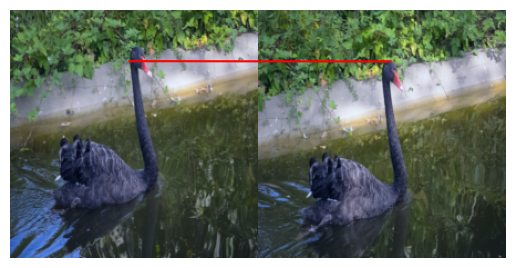

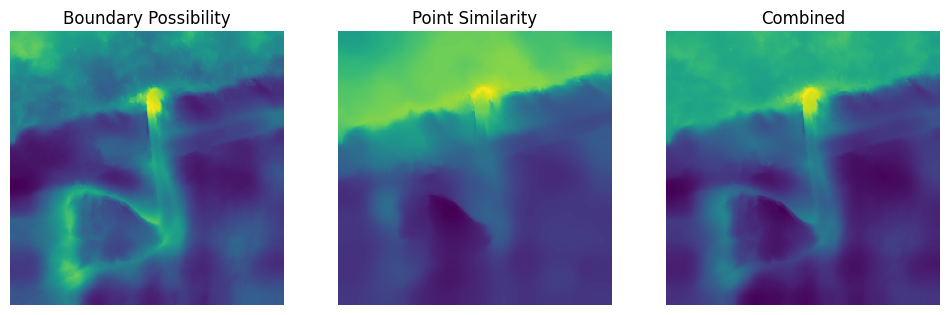

In [416]:
video_idx = 2
frame_source_idx = 0
frame_target_idx = 30
neighor_size = 28
source_img_tensor, source_mask, source_points = val_infer_set.raw_data_set[video_idx][
    frame_source_idx
]
target_img_tensor, target_mask, target_points_set = val_infer_set.raw_data_set[video_idx][
    frame_target_idx
]
source_img = normalize(source_img_tensor).permute(1, 2, 0).numpy()
target_img = normalize(target_img_tensor).permute(1, 2, 0).numpy()
total_img = np.concatenate([source_img, target_img], axis=1)
plt.imshow(total_img)
source_points = source_points.clamp(0, 223).numpy()
point_colors = ["r", "g", "b", "y", "m", "c"]
color_array = np.array([point_colors[i % len(point_colors)] for i in range(source_points.shape[0])])
# plt.scatter(source_points[:, 0], source_points[:, 1], c=color_array, s=5)
source_feats = featup(source_img_tensor.unsqueeze(0).cuda()).squeeze(0)
target_feats = featup(target_img_tensor.unsqueeze(0).cuda()).squeeze(0)
point_idx = 0
source_point = source_points[point_idx]
# plt.scatter(source_point[0], source_point[1], c='r', s=5)
source_feat = source_feats[:, source_point[1].astype(int), source_point[0].astype(int)]
img_offset = source_img.shape[1]
closest_point = find_closest_point(target_feats, source_feats, torch.tensor(source_point), img_offset, neighor_size)
# plt.scatter(closest_point[1], closest_point[0], c='b', s=5)
plt.plot([source_point[0], closest_point[0]], [source_point[1], closest_point[1]], c='r')
plt.axis("off")
plt.show()
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.axis("off")
plt.title("Boundary Possibility")
target_bou_poss = featup_wrapper_fir_classifier.boundary_classifier(target_img_tensor.unsqueeze(0).cuda())[0]
target_bou_poss = target_bou_poss / target_bou_poss.max()
plt.imshow(target_bou_poss.cpu().detach().numpy())
plt.subplot(1, 3, 2)
plt.title("Point Similarity")
target_similarity = find_closest_matrix(target_feats, source_feats, torch.tensor(source_point), img_offset, neighor_size)
target_similarity = target_similarity / target_similarity.max()
plt.imshow(target_similarity.cpu().detach().numpy())
plt.axis("off")
plt.subplot(1, 3, 3)
plt.title("Combined")
combined_similarity = target_similarity + target_bou_poss
plt.imshow(combined_similarity.cpu().detach().numpy())
plt.axis("off")
plt.show()

In [435]:
val_inferer.infer_all_videos(featup_wrapper_fir_classifier, use_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [17:58<00:00, 18.93s/it]


In [438]:
val_inferer.compute_all_videos_iou()

0.26023600474755665

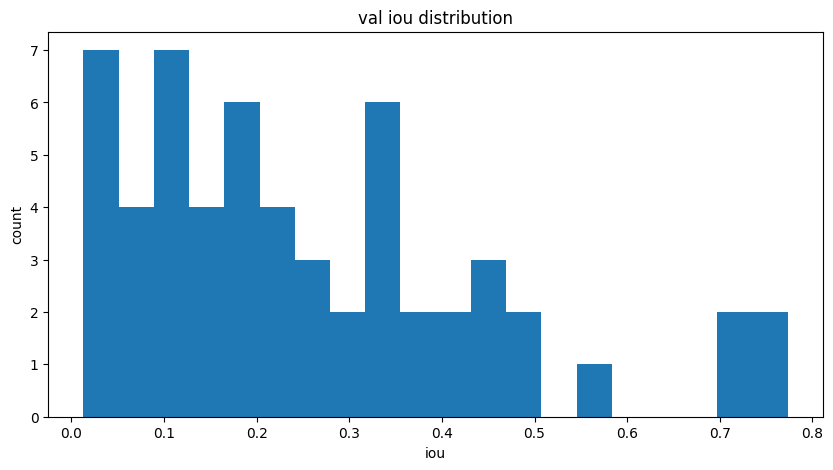

In [437]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 7, 22]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

## Binary Classification

In [13]:
class FocalLoss(nn.Module):
    def __init__(
        self,
    ):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets):
        return ops.sigmoid_focal_loss(inputs, targets, reduction="mean")

In [11]:
class BinaryClassifier(nn.Module):
    def __init__(
        self,
        freeze_featup: bool = True,
    ) -> None:
        super().__init__()
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        ).cuda()
        if freeze_featup:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_model = 384
        self.classifier = MLP(d_model, d_model, 1, 3).cuda()

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        img_feats = self.featup(img)
        img_feats = rearrange(img_feats, "b c h w -> b (h w) c")
        pred_bou_results = self.classifier(img_feats)
        pred_bou_results = rearrange(
            pred_bou_results, "b (h w) () -> b h w", h=img.shape[2], w=img.shape[3]
        )
        return pred_bou_results

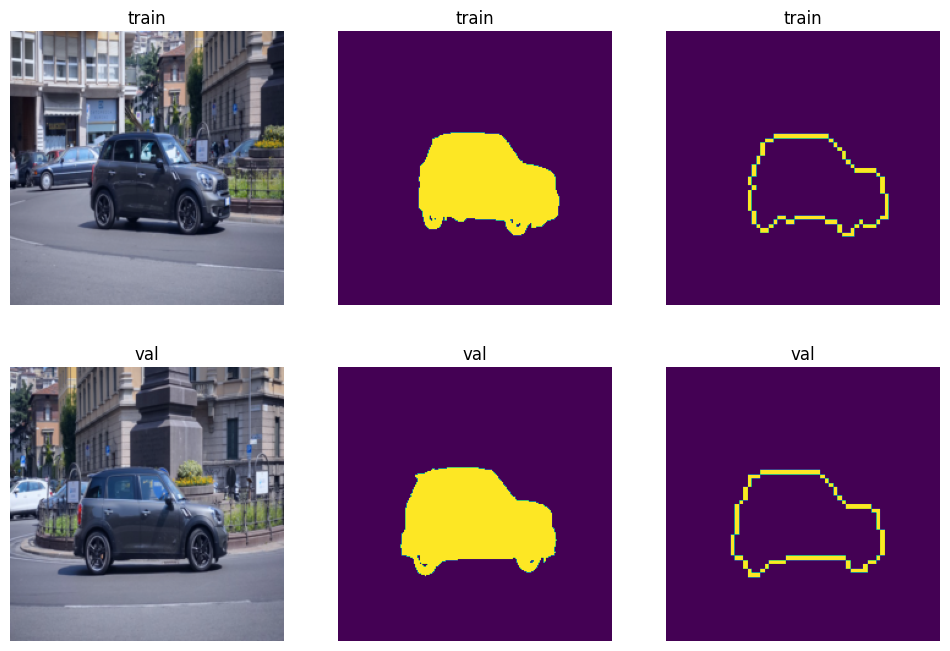

In [9]:
video_idx = 7
frame_idx = 0
img_tensor, mask, points = val_infer_set.raw_data_set[video_idx][frame_idx]
val_frame_idx = 25
val_img_tensor, val_mask, val_points = val_infer_set.raw_data_set[video_idx][val_frame_idx]
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title("train")
plt.axis("off")
plt.imshow(normalize(img_tensor).permute(1, 2, 0).cpu().numpy())
plt.subplot(2, 3, 2)
plt.title("train")
plt.axis("off")
plt.imshow(mask.cpu())
plt.subplot(2, 3, 3)
plt.title("train")
plt.axis("off")
boundary_img_tensor = get_binary_boundary_mask(mask, 64, "cuda")
plt.imshow(boundary_img_tensor.cpu())
plt.subplot(2, 3, 4)
plt.title("val")
plt.axis("off")
plt.imshow(normalize(val_img_tensor).permute(1, 2, 0).cpu().numpy())
plt.subplot(2, 3, 5)
plt.title("val")
plt.axis("off")
plt.imshow(val_mask.cpu())
plt.subplot(2, 3, 6)
plt.title("val")
plt.axis("off")
val_boundary_img_tensor = get_binary_boundary_mask(val_mask, 64, "cuda")
plt.imshow(val_boundary_img_tensor.cpu())
plt.show()

In [14]:
binary_classifier = BinaryClassifier(featup).cuda()
focal_loss = FocalLoss()
optimizer = torch.optim.Adam(binary_classifier.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [15]:
loss_dict = {}
val_loss_dict = {}
epoch_num =  60

In [16]:
for e in range(epoch_num):
    total_loss = 0.0
    pred_bou_results = binary_classifier(img_tensor.unsqueeze(0).cuda())
    # print(pred_bou_results.shape, boundary_img_tensor.shape)
    loss = focal_loss(pred_bou_results, boundary_img_tensor.unsqueeze(0))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    loss_dict[e] = total_loss / len(val_infer_set.raw_data_set)
    val_loss = 0.0
    val_pred_bou_results = binary_classifier(val_img_tensor.unsqueeze(0).cuda())
    val_loss = focal_loss(val_pred_bou_results, val_boundary_img_tensor.unsqueeze(0))
    val_loss_dict[e] = val_loss.item()
    print(f"epoch {e} loss: {loss_dict[e]} val_loss: {val_loss.item()}")

/work3/s232248/miniconda3/envs/rd/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch 0 loss: 0.0018925047234485024 val_loss: 0.09572148323059082
epoch 1 loss: 0.001708521654731349 val_loss: 0.08930753171443939
epoch 2 loss: 0.0015292155899499591 val_loss: 0.08113561570644379
epoch 3 loss: 0.0013981300749276813 val_loss: 0.07408904284238815
epoch 4 loss: 0.0012241486917462265 val_loss: 0.06631231307983398
epoch 5 loss: 0.0011013525358417578 val_loss: 0.060882508754730225
epoch 6 loss: 0.0010531393713072727 val_loss: 0.050697606056928635
epoch 7 loss: 0.0009113959968090057 val_loss: 0.04897330701351166
epoch 8 loss: 0.0008057979376692521 val_loss: 0.04449388012290001
epoch 9 loss: 0.0007252426523911325 val_loss: 0.040151990950107574
epoch 10 loss: 0.0006074726973709307 val_loss: 0.03412807732820511
epoch 11 loss: 0.0005876289909346062 val_loss: 0.03465018421411514
epoch 12 loss: 0.0005329710088278118 val_loss: 0.029474925249814987
epoch 13 loss: 0.0004905368805977336 val_loss: 0.024969644844532013
epoch 14 loss: 0.0004786122590303421 val_loss: 0.0264008529484272
ep

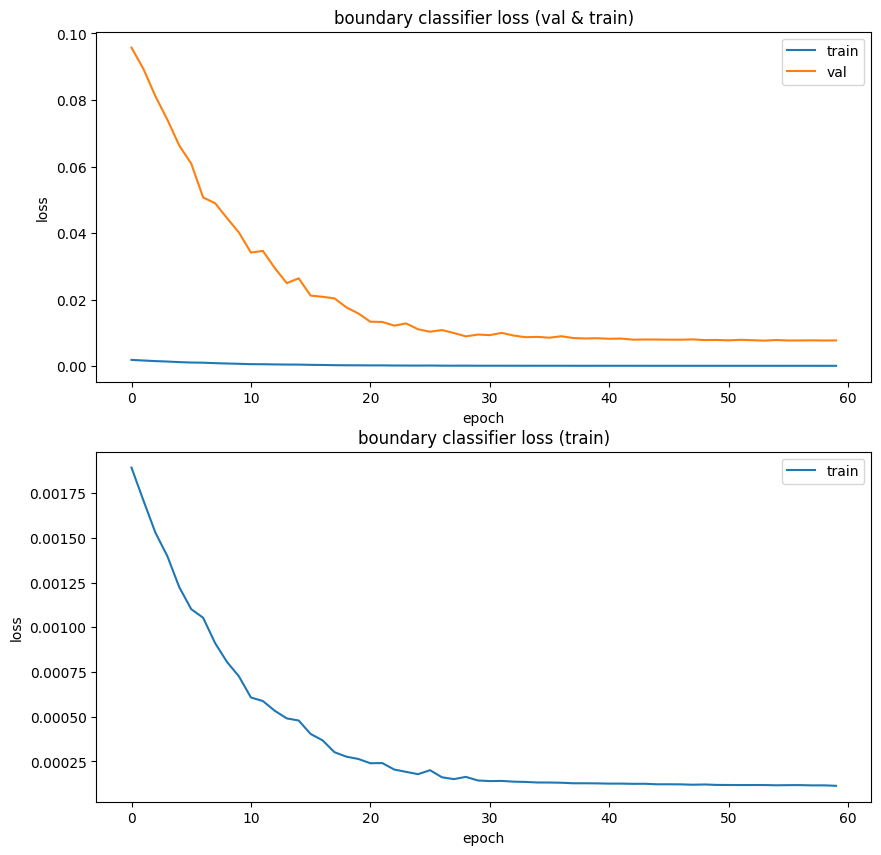

In [18]:
# plot the loss curve
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="train")
plt.plot(list(val_loss_dict.keys()), list(val_loss_dict.values()), label="val")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("boundary classifier loss (val & train)")
plt.subplot(2, 1, 2)
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="train")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("boundary classifier loss (train)")
plt.show()

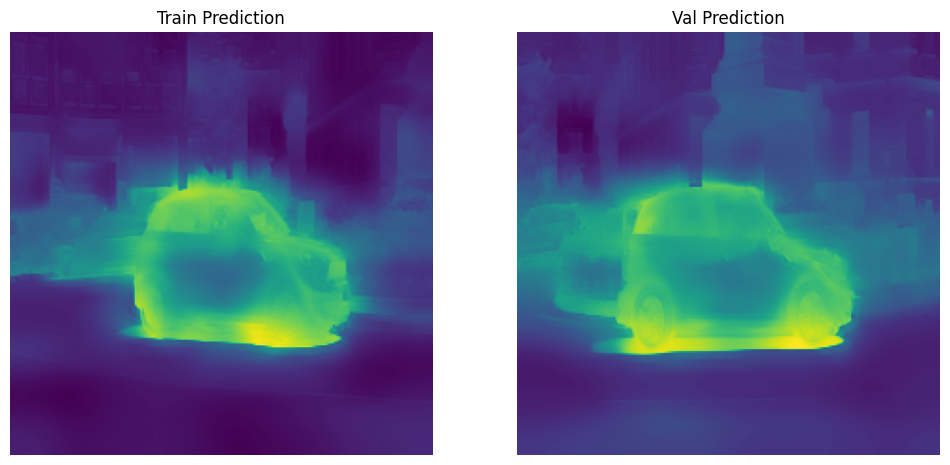

In [19]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(pred_bou_results[0].sigmoid().cpu().detach().numpy())
plt.axis("off")
plt.title("Train Prediction")
plt.subplot(1, 2, 2)
plt.imshow(val_pred_bou_results[0].sigmoid().cpu().detach().numpy())
plt.axis("off")
plt.title("Val Prediction")
plt.show()